In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATASETS = 'datasets/sf-police-calls-for-service-and-incidents/'

# Police Reports

In [3]:
# import datasets
og_accidents_df = pd.read_csv(DATASETS + 'police-department-incidents.csv')
og_calls_df = pd.read_csv(DATASETS + 'police-department-calls-for-service.csv')

## Data Investigation to Grab Call Date Time Data for Discretizing

In [4]:
# Creating our DF of only Call Date Time data
cdt_df = og_calls_df["Call Date Time"]

# Check data types of objects in CDT DF
# type(cdt_df)   # should return 'Series' object

print("total: {}, unique: {}".format(len(cdt_df), len(cdt_df.unique())))

len(cdt_df[cdt_df.isna() == True])    # should return zero (0)

cdt_df.head()

# GOAL: bucketing timeranges from midnight to 23:59:59 while conserving dates

# First step: sort the CDT data by dates (pre-T)
# Second step: Grab 

total: 2088982, unique: 990300


0    2016-04-03T18:15:00
1    2016-04-02T03:55:00
2    2016-04-03T11:49:00
3    2016-04-01T16:09:00
4    2016-04-01T19:11:00
Name: Call Date Time, dtype: object

In [5]:
og_calls_df.head(2)

,Crime Id,Original Crime Type Name,Report Date,Call Date,Offense Date,Call Time,Call Date Time,Disposition,Address,City,State,Agency Id,Address Type,Common Location
0,160942891,Muni Inspection,2016-04-03T00:00:00,2016-04-03T00:00:00,2016-04-03T00:00:00,18:15,2016-04-03T18:15:00,Not recorded,900 Block Of Ulloa St,San Francisco,CA,1,Common Location,"West Portal Muni, Sf"
1,160930487,913,2016-04-02T00:00:00,2016-04-02T00:00:00,2016-04-02T00:00:00,03:55,2016-04-02T03:55:00,HAN,Folsom St/13th St,San Francisco,CA,1,Intersection,NaN


In [6]:
og_accidents_df.head(2)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,50436712,ASSAULT,BATTERY,Wednesday,2005-04-20T00:00:00,04:00,MISSION,NONE,18TH ST / CASTRO ST,-122.435003,37.760888,"{'latitude': '37.7608878061245', 'longitude': ...",5043671204134
1,80049078,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Sunday,2008-01-13T00:00:00,18:00,PARK,NONE,1100 Block of CLAYTON ST,-122.446838,37.762255,"{'latitude': '37.7622550270122', 'longitude': ...",8004907806304


# Data Wrangling
1. Cleaning the data
1. Helper functions

In [7]:
# Drop row if count is less than given value
def drop_if_count(islessthan, columnname, dataframe):
    hist = dataframe[columnname].value_counts()[::-1]
    labels_to_remove = []
    for label, count in hist.iteritems():
        if count <= islessthan:
            labels_to_remove.append(label)
        else:
            break

    indexes_to_drop = dataframe.loc[dataframe[columnname].isin(labels_to_remove)].index
    
    return dataframe.drop(indexes_to_drop)

In [8]:

# Drop Report Date
calls_df = og_calls_df.drop(columns=['Report Date'], errors='ignore')

# Rearange columns
calls_df = calls_df[['Crime Id', 'Original Crime Type Name', 'Call Date', 'Call Time', 'Call Date Time', 'Offense Date', 'Address', 'City', 'State', 'Address Type', 'Common Location', 'Disposition', 'Agency Id']]

# drop uncommon crimes that are 100 calls or less
calls_df = drop_if_count(islessthan=100, columnname='Original Crime Type Name', dataframe=calls_df)

# drop uncommon common locations that are 100 calls or less
calls_df = drop_if_count(islessthan=100, columnname='Common Location', dataframe=calls_df)

# convert dates into pd.datetime objects
calls_df['Call Date Time'] = pd.to_datetime(calls_df['Call Date Time'])

# Replace codes with their titles
def refactor_codes(value):
    if value == "601":
        return "Trespasser (201)"
    elif value == "909":
        return "Interview a citizen (909)"
    elif value.lower() == "22500e":
        return "Vehicle blocking a (22500e)"
    elif value == "22500f":
        return "Parking on Sidewalk (22500f)"
    elif value.lower() == "rep":
        return "Report (Rep)"

    return value
        
calls_df['Original Crime Type Name'] = calls_df['Original Crime Type Name'].apply(refactor_codes)

# Rename Columns
calls_df = calls_df.rename(columns={
    'Crime Id': 'crime_id',
    'Original Crime Type Name': 'original_crime_type_name',
    'Call Date': 'call_date',
    'Call Time': 'call_time',
    'Call Date Time': 'call_datetime',
    'Offense Date': 'offense_date',
    'Address': 'address',
    'City': 'city',
    'State': 'state',
    'Address Type': 'address_type',
    'Common Location': 'common_location',
    'Disposition': 'disposition',
    'Agency Id': 'agency_id',
})

In [9]:
calls_df.head(1)

,crime_id,original_crime_type_name,call_date,call_time,call_datetime,offense_date,address,city,state,address_type,common_location,disposition,agency_id
0,160942891,Muni Inspection,2016-04-03T00:00:00,18:15,2016-04-03 18:15:00,2016-04-03T00:00:00,900 Block Of Ulloa St,San Francisco,CA,Common Location,"West Portal Muni, Sf",Not recorded,1


# Wrangle accidents_df

 ¯\_(ツ)_/¯ 

# Questions
1. What are the most common locations
1. What is the top reported crime
1. Are there any trends in the reports or a specific crime
1. For each hour, how many crimes are reported and when do crimes have their peaks and local minimums.

#### For later
1. Where are the top common crimes reported at (heat map)
1. throughout 24hrs, where are the most calls for each location at a given hour (heat map)

# About the data
1. There are no `nan` values for Call Datetime, Crime Type
1. The oldest row is March 2016
1. The most recent row is October 2018

In [10]:
# date range of this data
from datetime import datetime

oldest = calls_df.call_date.min()
latest = calls_df.call_date.max()

# format the date to look pretty here https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
print("Oldest date {}.\n\nMost recent date {}".format(oldest, latest))

Oldest date 2016-03-30T00:00:00.

Most recent date 2018-10-06T00:00:00


In [11]:
# common locations
hist_common_locations = calls_df.common_location.value_counts()

print(hist_common_locations[:10])

print("\n# of Reports {}, # of common locations {}".format(len(calls_df), hist_common_locations.sum()))

Un Pz, Sf                       6627
Haight St Corridor              5114
Twin Peaks Viewpoint, Sf        3863
One Hallidie Pz, Sf             3863
Powell St Muni, Sf              3616
Un Pz                           3305
Embarcadero Muni Station, Sf    3199
Twin Peaks Viewpoint            2890
Civic Center Muni, Sf           2785
Mission Station, Sf             2780
Name: common_location, dtype: int64

# of Reports 1992033, # of common locations 162354


In [12]:
# df = calls_df.sort_values(by=['call_datetime'])

For each hour, how many crimes are reported and when do crimes have their peaks and local minimums.

In [13]:

def reports_between(start_time, end_time, column, dataframe):
    """
    slice the given dataframe by the given start and end times
    
    returns: new data frame with the given date column now as the index
    """
    
    df = dataframe.set_index(column)
    sliced = df.between_time(start_time, end_time)
    
    return sliced

def value_counts_for(dataframe, column, title):
    """
    counts the number of reports for the given dataframe and buckets the call_datetime from midnight to end of day
    
    returns: new data frame of the counts of each hour from 0:00 to 23:00 inclusive
    """
    
    hours = ["{}:00".format(hour) for hour in range(24)]
    hours.append("23:59")
    
    hist_df = pd.DataFrame()
    counts = np.array([])
    
    for i in range(len(hours) -1):
        start_time, end_time = hours[i], hours[i +1]
        
        reports = reports_between(start_time, end_time, column, dataframe)
        counts = np.append(counts, len(reports))
        
    hist_df[title] = pd.Series(counts, dtype='int64', index=hours[:-1])
    
    return hist_df

crime_per_hour_df = value_counts_for(calls_df, 'call_datetime', 'Number of Calls')

In [14]:
crime_per_hour_df.head(1)

,Number of Calls
0:00,61577


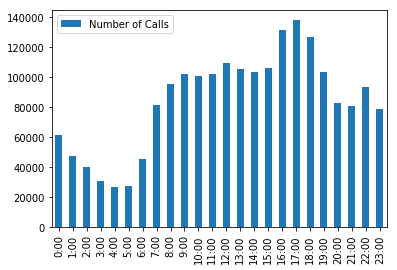

In [15]:
# Number of All Reports throughout the full day
crime_per_hour_df.plot(kind='bar')

In [16]:
# Histogram of top 10 calls crime types
# pd.set_option('display.max_rows', 50)
hist_crimes = calls_df.original_crime_type_name.value_counts().sort_values(ascending=False)
sliced_at = 10
top_crimes = hist_crimes[:sliced_at]

What is the top reported crime

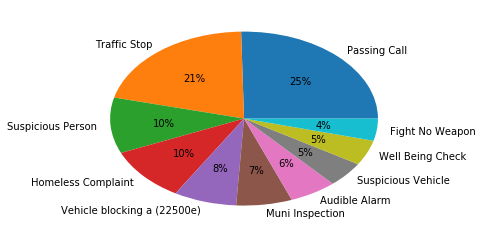

In [17]:
# Top 10 crimes
plt.pie(top_crimes, labels=top_crimes.index, autopct='%1.0f%%')
plt.show()

In [18]:
top_crimes_factored = top_crimes.apply(lambda i: i / 1_000)

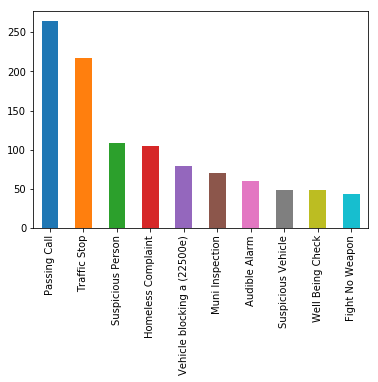

In [19]:
# Number of reports for the top crimes
top_crimes_factored.plot(kind='bar')

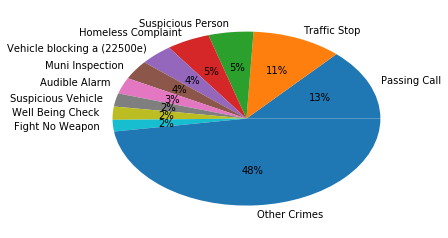

In [20]:
# Add the count of all other crimes
other_crimes = hist_crimes[sliced_at:]
top_crimes = top_crimes.append(pd.Series({"Other Crimes": other_crimes.sum()}))

# Plot
plt.pie(top_crimes, labels=top_crimes.index, autopct='%1.0f%%')
plt.show()

For each hour, how many crimes are reported and when do crimes have their peaks and local minimums for the following:

1. Passing Calls
1. Traffic Calls
1. Suspicious Person Calls
1. Muni Inspection Calls
1. Fight, No Weapon Calls

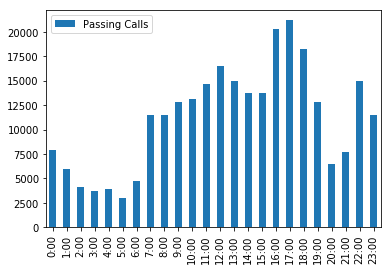

In [21]:
# Passing Calls
passing_calls_df = value_counts_for(calls_df[calls_df.original_crime_type_name == "Passing Call"], 'call_datetime', "Passing Calls")
passing_calls_df.plot(kind='bar')

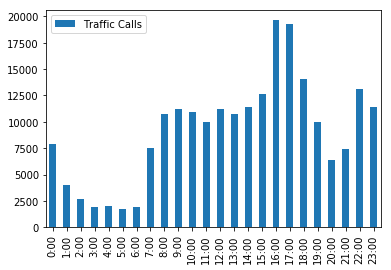

In [22]:
# Traffic Calls
traffic_calls_df = value_counts_for(calls_df[calls_df.original_crime_type_name == "Traffic Stop"], 'call_datetime', "Traffic Calls")
traffic_calls_df.plot(kind='bar')

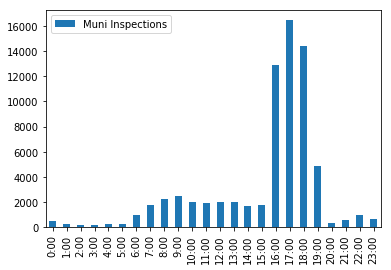

In [23]:
# Muni Inspection
muni_inspection_calls_df = value_counts_for(calls_df[calls_df.original_crime_type_name == "Muni Inspection"], 'call_datetime', "Muni Inspections")
muni_inspection_calls_df.plot(kind='bar')

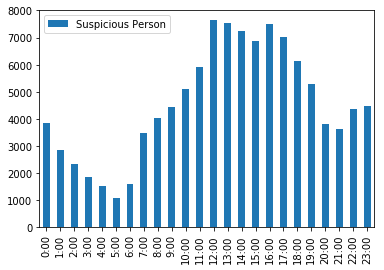

In [24]:
# Suspicious Person
suspicious_person_calls_df = value_counts_for(calls_df[calls_df.original_crime_type_name == "Suspicious Person"], 'call_datetime', "Suspicious Person")
suspicious_person_calls_df.plot(kind='bar')

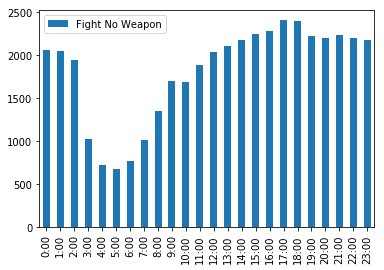

In [25]:
# Fight, no weapon
fight_no_weapon_calls_df = value_counts_for(calls_df[calls_df.original_crime_type_name == "Fight No Weapon"], 'call_datetime', "Fight No Weapon")
fight_no_weapon_calls_df.plot(kind='bar')

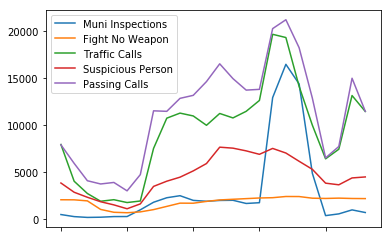

In [26]:
# Top crimes together
top_crimes_df = pd.concat([
    muni_inspection_calls_df, 
    fight_no_weapon_calls_df, 
    traffic_calls_df, 
    suspicious_person_calls_df,
    passing_calls_df
], axis=1)

top_crimes_df.plot()

# Stats
1. Is there a trend, for all crime types, for a given day between 2016 and today?

In [27]:

# create a dataframe that contains the number of crimes for every given hour for every existing datetime
def value_counts_for_every_hour(dateframe, column):
    
    hist_calls = {}
    for a_report in dateframe[column]:
        year = a_report.year
        month = a_report.month
        day = a_report.day
        hour = a_report.hour
        minute = a_report.minute
        
        a_report_key = datetime(year, month, day, hour)
        
        hist_calls[a_report_key] = hist_calls.get(a_report_key, 0) +1
        
    n_calls = list(hist_calls.values())
    years = list()
    months = list()
    days = list()
    hours = list()
    keys = list()
    for an_index in hist_calls.keys():
        keys.append(an_index)
        years.append(an_index.year)
        months.append(an_index.month)
        days.append(an_index.day)
        hours.append(an_index.hour)
        
    df = pd.DataFrame({"#Calls": n_calls, "year": years, "month": months, "day": days, "hour": hours}, index=keys, dtype='int64')
    
    return df

# df = pd.read_csv('datasets/AirPassengers.csv')
# df['Month'] = pd.to_datetime(df['Month'])
# df = df.set_index(['Month'])

crime_counts_per_hour_df = value_counts_for_every_hour(calls_df, 'call_datetime')

In [28]:
crime_counts_per_hour_df.head(1)

,#Calls,year,month,day,hour
2016-04-03 18:00:00,103,2016,4,3,18


In [29]:
crime_counts_per_hour_df = crime_counts_per_hour_df.sort_index()
print(crime_counts_per_hour_df.head(1))
print(crime_counts_per_hour_df.tail(1))

                     #Calls  year  month  day  hour
2016-03-30 18:00:00       1  2016      3   30    18
                     #Calls  year  month  day  hour
2018-10-06 23:00:00      54  2018     10    6    23


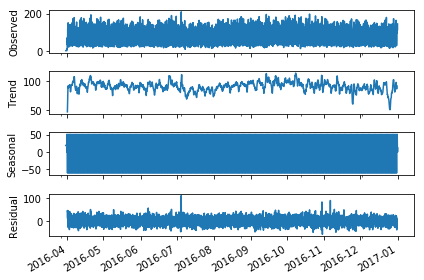

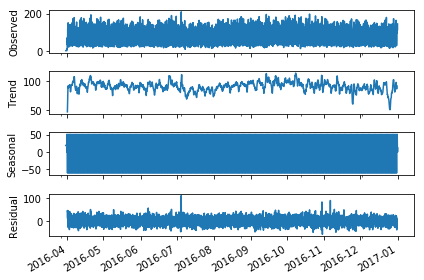

In [30]:
import statsmodels.api as sm

crime_2016_s = crime_counts_per_hour_df[crime_counts_per_hour_df.year == 2016]["#Calls"]
decomposition = sm.tsa.seasonal_decompose(crime_2016_s, freq=24, model='additive')
decomposition.plot()

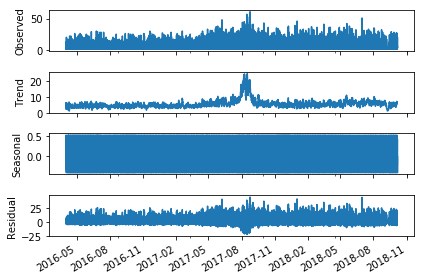

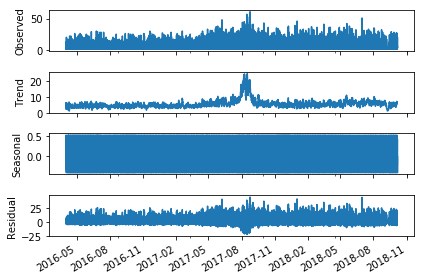

In [31]:
import statsmodels.api as sm

muni_calls_s = value_counts_for_every_hour(calls_df[calls_df.original_crime_type_name == "Muni Inspection"], 'call_datetime')["#Calls"]
decomposition = sm.tsa.seasonal_decompose(muni_calls_s, freq=24, model='additive')
decomposition.plot()

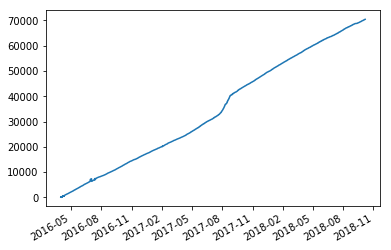

In [32]:
# Cummulative sum
muni_calls_s.cumsum().plot()

# Conclusion

